In [1]:
import numpy as np
import bpy
import matplotlib.pyplot as plt
import shapely.wkt
import geopandas as gpd
import tripy
import optimesh
import warnings
import torch
import colorsys
import math
import skimage

from shapely.geometry import Polygon, LineString
from shapely.ops import triangulate, unary_union, cascaded_union
from matplotlib.lines import Line2D
from geovoronoi import voronoi_regions_from_coords
from quad_mesh_simplify import simplify_mesh
from collections import OrderedDict
from utils.earclip import triangulate
from torch_geometric.data import Data

/home/ivy8792/anaconda3/envs/bpy/lib/python3.10/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/ivy8792/anaconda3/envs/bpy/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/ivy8792/anaconda3/envs/bpy/lib/python3.10/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/ivy8792/anaconda3/envs/bpy/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [114]:
# import file
file_path = "./datasets/svg/011-library.svg"
# file_path = "./datasets/svg/027-diamond.svg"
# file_path = "./datasets/svg/019-watermelon.svg"
# file_path = "./datasets/svg/024-book.svg"
# file_path = "./datasets/svg/060-reload-20230124.svg"
# file_path = "./datasets/svg/044-mobile phone.svg"
file_path = "./datasets/svg/053-weather.svg"
# file_path = "./datasets/svg/011-cloudy.svg"

# clean the scene
bpy.ops.object.select_all()
bpy.ops.object.delete()

bpy.ops.import_curve.svg(filepath=file_path)

{'FINISHED'}

In [115]:
# rescale
curve_objs = [ob for ob in bpy.data.objects if ob.type == "CURVE"]
bpy.ops.object.select_all(action="DESELECT")
for ob in curve_objs:
    ob.select_set(True)
bbox = [ob.bound_box for ob in curve_objs]
x_size = max(p[0] for b in bbox for p in b) - min(p[0] for b in bbox for p in b)
y_size = max(p[1] for b in bbox for p in b) - min(p[1] for b in bbox for p in b)
scale = 0.1 / max(x_size, y_size)
bpy.ops.transform.resize(value=(scale, scale, scale))
bpy.ops.object.select_all(action="DESELECT")

In [116]:
# convert curve to mesh
idx = 0
for ob in bpy.data.objects:
    if ob.type == "CURVE":
        mesh = bpy.data.meshes.new_from_object(ob)
        new_obj = bpy.data.objects.new("mesh_obj" + str(idx), mesh)
        new_obj.matrix_world = ob.matrix_world
        bpy.context.collection.objects.link(new_obj)
        idx += 1

In [117]:
# get all curve meshes
colors = {}
nodes = {}
idx = 0
hsv = {}
lab = {}
for ob in bpy.data.objects:
    if ob.type == "MESH" and "mesh_obj" in ob.name:
        try:
            # get mesh
            rgb = ob.material_slots[0].material.diffuse_color
            colors[idx] = np.array([rgb[0], rgb[1], rgb[2]])
            hsv[idx] = np.array(colorsys.rgb_to_hsv(rgb[0], rgb[1], rgb[2]))
            l, a, b = np.array(skimage.color.rgb2lab([rgb[0], rgb[1], rgb[2]]))
            l, a, b = l/100, (a+128)/256, (b+128)/256
            lab[idx] = [l, a, b]
            
            # get vertices
            v = ob.data.vertices[0]
            coords = [(ob.matrix_world @ v.co) for v in ob.data.vertices]  # (x, y, z)
            nodes[idx] = []
            for x, y, z in coords:
                nodes[idx].append([x, y]) 
            nodes[idx] = np.array(nodes[idx])
            
            idx += 1
        except:
            continue

In [118]:
poly_nodes = {}
all_polys = []
idx = 0
group_x = []

for i, points in nodes.items():
    if len(points) < 4: continue
    poly = Polygon(points).buffer(0.001)
    all_polys.append(poly)
    
    # w/ simplification
    sim = poly.simplify(0.0001, preserve_topology=True)
    poly_nodes[idx] = []
    if sim.geom_type == "MultiPolygon":
        coords_list = [list(x.exterior.coords) for x in sim.geoms]
        for c in coords_list:
            for x, y in c:
                poly_nodes[idx].append([x, y])
    else:
        xx, yy = sim.exterior.coords.xy
        for x, y in zip(xx, yy):
            poly_nodes[idx].append([x, y])
    
    # # w/o simplification
    # poly_nodes[idx] = []
    # if poly.geom_type == "MultiPolygon":
    #     coords_list = [list(x.exterior.coords) for x in poly.geoms]
    #     for c in coords_list:
    #         for x, y in c:
    #             poly_nodes[idx].append([x, y])
    # else:
    #     xx, yy = poly.exterior.coords.xy
    #     for x, y in zip(xx, yy):
    #         poly_nodes[idx].append([x, y])
            
    # center of closed curve
    x_mean = np.mean(np.array(poly_nodes[idx])[:, 0])
    y_mean = np.mean(np.array(poly_nodes[idx])[:, 1])
    group_x.append([x_mean, y_mean])
            
    idx += 1

In [119]:
all_points = []
all_edges = []
all_rgb = []
all_hsv = []
all_lab = []
all_cluster = []
idx = 0

for i, p in poly_nodes.items():
    cnt = 0
    first_idx = idx
    for j in range(len(p)-1):
        all_points.append(p[j])
        if j < len(p)-2: all_edges.append([idx, idx+1])
        else: all_edges.append([idx, first_idx])
        idx += 1
        cnt += 1
        
    all_cluster += [i for _ in range(cnt)]
    
    # all_rgb += [colors[i].tolist()]
    # all_hsv += [hsv[i].tolist()]
        
    rgb_temp = [colors[i].tolist()] * cnt
    hsv_temp = [hsv[i].tolist()] * cnt
    lab_temp = [lab[i]] * cnt
    if i == 0:
        all_rgb = rgb_temp
        all_hsv = hsv_temp
        all_lab = lab_temp
    else:
        all_rgb = np.concatenate((all_rgb, rgb_temp), axis=0)
        all_hsv = np.concatenate((all_hsv, hsv_temp), axis=0)
        all_lab = np.concatenate((all_lab, lab_temp), axis=0)
      
all_points = np.array(all_points)
all_edges = np.array(all_edges)
all_rgb = np.array(all_rgb)
all_hsv = np.array(all_hsv)
all_lab = np.array(all_lab)
all_cluster = np.array(all_cluster)
all_h = (np.round(all_hsv[:,0]*10)%10).astype(np.int64)
group_x = np.array(group_x)

pos_edge_label_index = np.array(list(range(len(all_edges))))
 
print(f"number of all points: {len(all_points)}; type: {type(all_points)}; shape: {all_points.shape}")
print(f"number of all edges: {len(all_edges)}; type: {type(all_edges)}; shape: {all_edges.shape}")
print(f"rgb: {all_rgb.shape}; hsv: {all_hsv.shape}; lab: {all_lab.shape}; cluster: {all_cluster.shape}")

number of all points: 352; type: <class 'numpy.ndarray'>; shape: (352, 2)
number of all edges: 352; type: <class 'numpy.ndarray'>; shape: (352, 2)
rgb: (352, 3); hsv: (352, 3); lab: (352, 3); cluster: (352,)


In [120]:
# check overlap
def block_intersect(i, j, poly1, poly2, group_edges, group_edges_type):
    a1 = poly1.area
    a2 = poly2.area
    intersect = poly1.intersection(poly2).area
    dis = poly1.distance(poly2)
    
    if abs(intersect - min(a1, a2)) < 0.000001:  # contain
        pass
    elif intersect != 0:  # overlap
        intersect = 1 / (intersect * 100)
        group_edges.append([i, j])
        group_edges.append([j, i])
        group_edges_type.append([intersect])
        group_edges_type.append([intersect])
        
    
    # if abs(intersect - min(a1, a2)) < 0.000001:  # in
    #     group_edges.append([i, j])
    #     group_edges.append([j, i])
    #     group_edges_type.append(2)
    #     group_edges_type.append(2)
    # elif intersect != 0:  # overlap
    #     group_edges.append([i, j])
    #     group_edges.append([j, i])
    #     group_edges_type.append(1)
    #     group_edges_type.append(1)
        
        
    return group_edges, group_edges_type

# check group connection
group_edges = []
group_edges_type = []
for i in range(len(all_polys)-1):
    for j in range(i+1, len(all_polys)):
        group_edges, group_edges_type = block_intersect(i, j, all_polys[i], all_polys[j], group_edges, group_edges_type)

/home/ivy8792/anaconda3/envs/bpy/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


In [121]:
# create pyg data
y_rgb = torch.Tensor(all_rgb)
y_hsv = torch.Tensor(all_hsv)
y_lab = torch.Tensor(all_lab)
y_h = torch.Tensor(all_h)
y_cluster = torch.Tensor(all_cluster)

# nodes
# x = torch.Tensor(all_points)
n = all_points.shape[0]
x = np.zeros([n, 5]).astype(np.float32)
for i, points in enumerate(all_points):
    temp = np.concatenate(([0, 0, 0], points))
    x[i] = temp
x = torch.Tensor(x)

# edges
m = all_edges.shape[0]
edges = np.zeros([2*m, 2]).astype(np.int64)
# edge_attr = np.zeros([2*m, 4]).astype(np.float32)
edge_attr = np.zeros([2*m, 2]).astype(np.float32)
for e, (s,t) in enumerate(all_edges):
    edges[e, 0] = s
    edges[e, 1] = t
    edges[m+e, 0] = t
    edges[m+e, 1] = s
    
    # edge_attr[e, :2] = all_points[s]
    # edge_attr[e, 2:] = all_points[t]
    # edge_attr[m+e, :2] = all_points[t]
    # edge_attr[m+e, 2:] = all_points[s]
    
    (x1, y1), (x2, y2) = all_points[s], all_points[t]
    distance = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    angle = math.atan2(y2 - y1, x2 - x1)
    edge_attr[e] = [distance, angle]
    edge_attr[m+e] = [distance, angle]
    
edges = torch.Tensor(np.transpose(edges)).type(torch.long)
edge_attr = torch.Tensor(edge_attr)

group_x = torch.Tensor(group_x)
group_edges = torch.Tensor(np.transpose(group_edges)).type(torch.long)
# group_edge_attr = torch.Tensor(np.expand_dims(np.array(group_edges_type), axis=1))
group_edge_attr = torch.Tensor(group_edges_type).type(torch.float)

In [122]:
data = Data(x=x,
            edge_index=edges,
            rgb=y_rgb,
            hsv=y_hsv,
            lab=y_lab,
            h = y_h,
            edge_attr=edge_attr,
            cluster=y_cluster,
            group_x=group_x,
            group_edge_index=group_edges,
            group_edge_attr=group_edge_attr,)
print(data)

Data(x=[352, 5], edge_index=[2, 704], edge_attr=[704, 2], rgb=[352, 3], hsv=[352, 3], lab=[352, 3], h=[352], cluster=[352], group_x=[18, 2], group_edge_index=[2, 2], group_edge_attr=[2, 1])


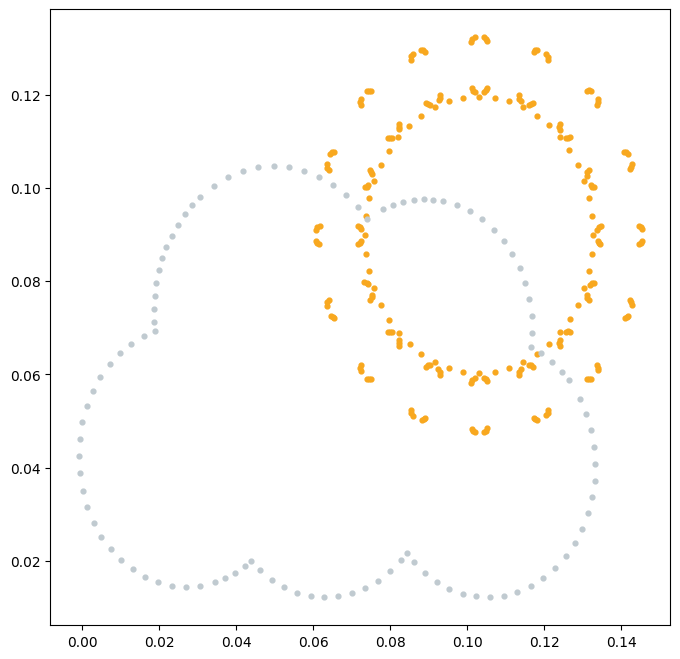

In [123]:
fig = plt.figure("plot", figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
# plt.axis("off")

arrowprops={'arrowstyle': '-',}
x_min, y_min = 1000000000, 1000000000
x_max, y_max = -100000000, -100000000


for i, p in enumerate(all_points):
    plt.scatter(p[0], p[1], s=12, color=all_rgb[i], label=all_cluster[i])

    # if p[0] > x_max: x_max = p[0]
    # elif p[0] < x_min: x_min = p[0]
    # if p[1] > y_max: y_max = p[1]
    # elif p[1] < y_min: y_min = p[1]
    
    # if i == 0:
    #     ax.annotate(all_cluster[i], (p[0], p[1]), fontsize=36, xytext=(p[0]+0.01, p[1]-0.01))
    # elif all_cluster[i] != all_cluster[i-1] and all_cluster[i] == 1:
    #     ax.annotate(all_cluster[i], (p[0], p[1]), fontsize=36, xytext=(p[0]+0.01, p[1]))
    # elif all_cluster[i] != all_cluster[i-1]:
    #     if all_cluster[i] == 1: ax.annotate(all_cluster[i], (p[0], p[1]), fontsize=36, xytext=(p[0], p[1]-0.01))
    #     elif all_cluster[i] == 2: ax.annotate(all_cluster[i], (p[0], p[1]), fontsize=36, xytext=(p[0], p[1]-0.01))
    #     elif all_cluster[i] == 3: ax.annotate(all_cluster[i], (p[0], p[1]), fontsize=36, xytext=(p[0], p[1]-0.01))
    #     elif all_cluster[i] == 4: ax.annotate(all_cluster[i], (p[0], p[1]), fontsize=36, xytext=(p[0]-0.005, p[1]-0.005))
    #     elif all_cluster[i] == 5: ax.annotate(all_cluster[i], (p[0], p[1]), fontsize=36, xytext=(p[0], p[1]-0.01))
    #     elif all_cluster[i] == 6: ax.annotate(all_cluster[i], (p[0], p[1]), fontsize=36, xytext=(p[0], p[1]))
    #     elif all_cluster[i] == 7: ax.annotate(all_cluster[i], (p[0], p[1]), fontsize=36, xytext=(p[0], p[1]-0.01))
    #     elif all_cluster[i] == 8: ax.annotate(all_cluster[i], (p[0], p[1]), fontsize=36, xytext=(p[0]-0.005, p[1]-0.005))
    #     elif all_cluster[i] == 9: ax.annotate(all_cluster[i], (p[0], p[1]), fontsize=36, xytext=(p[0], p[1]-0.01))
        
    # if i == 2: ax.annotate(f"({round(p[0], 4)}, {round(p[1], 4)})", (p[0], p[1]), xytext=(p[0], p[1]+0.01), arrowprops=arrowprops, fontsize=20)
    # elif i == 1: ax.annotate(f"({round(p[0], 4)}, {round(p[1], 4)})", (p[0], p[1]), xytext=(p[0]+0.01, p[1]), arrowprops=arrowprops, fontsize=20)
    # elif i == 0: ax.annotate(f"({round(p[0], 4)}, {round(p[1], 4)})", (p[0], p[1]), xytext=(p[0]+0.01, p[1]-0.01), arrowprops=arrowprops, fontsize=20)
    # if i == 186:
    #     r, g, b = round(all_rgb[i][0], 2), round(all_rgb[i][1], 2), round(all_rgb[i][2], 2)
    #     h, s, v = round(all_hsv[i][0], 2), round(all_hsv[i][1], 2), round(all_hsv[i][2], 2)
    #     l, a, bb = round(all_lab[i][0], 2), round(all_lab[i][1], 2), round(all_lab[i][2], 2)
    #     ax.annotate(f"RGB: ({r}, {g}, {b})", (p[0], p[1]), xytext=(p[0]-0.08, p[1]+0.023), fontsize=20)
    #     ax.annotate(f"HSV: ({h}, {s}, {v})", (p[0], p[1]), xytext=(p[0]-0.08, p[1]+0.014), fontsize=20)
    #     ax.annotate(f"CIE-LAB: ({l}, {a}, {bb})", (p[0], p[1]), xytext=(p[0]-0.08, p[1]+0.005), fontsize=20, arrowprops=arrowprops)
    
# for n1, n2 in all_edges:
    
#     # if n1 == 58 and n2 == 59:
#     #     x1, y1 = all_points[n1]
#     #     x2, y2 = all_points[n2]
#     #     distance = round(math.sqrt((x2 - x1)**2 + (y2 - y1)**2), 6)
#     #     angle = round(math.atan2(y2 - y1, x2 - x1), 6)
#     #     l = Line2D([x1,x2], [y1,y2], alpha=1, color="black", linewidth=3, linestyle='--', )
#     #     ax.annotate(f"distance: {distance}", (x2, y2), xytext=(x2, y2+0.012), fontsize=20)
#     #     ax.annotate(f"angle: {angle}", (x2, y2), xytext=(x2, y2+0.004), fontsize=20)
#     #     ax.add_line(l)
    
#     x1, y1 = all_points[n1]
#     x2, y2 = all_points[n2]
#     l = Line2D([x1,x2], [y1,y2], alpha=0.5, color=all_rgb[n1])
#     ax.add_line(l)
        
# x_t = np.array([x_min, x_min+(x_max-x_min)*0.25, x_min+(x_max-x_min)*0.5, x_min+(x_max-x_min)*0.75, x_max])
# y_t = np.array([y_min, y_min+(y_max-y_min)*0.25, y_min+(y_max-y_min)*0.5, y_min+(y_max-y_min)*0.75, y_max])
# xx = x_t * 10 - x_min * 10
# yy = y_t * 10 - y_min * 10
# plt.xticks(ticks=x_t, labels=np.round(xx, 2), fontsize=40)
# plt.yticks(ticks=y_t, labels=np.round(yy, 2), fontsize=40)
# print(x_max, y_max)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
# plt.legend(by_label.values(), by_label.keys(), prop={'size': 20}, loc="upper left", markerscale=3)
plt.show()